# Libraries Used

In [2]:
# Libraries needed
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [3]:
df=pd.read_pickle("WM811K.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   dieSize         811457 non-null  float64
 1   failureType     811457 non-null  object 
 2   lotName         811457 non-null  object 
 3   trainTestLabel  811457 non-null  object 
 4   waferIndex      811457 non-null  float64
 5   waferMap        811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


In [4]:
df.head()

,dieSize,failureType,lotName,trainTestLabel,waferIndex,waferMap
0,1683.0,none,lot1,Training,1.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,1683.0,none,lot1,Training,2.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,1683.0,none,lot1,Training,3.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,1683.0,none,lot1,Training,4.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,1683.0,none,lot1,Training,5.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [5]:
max_col = 0
max_row = 0
min_col = 999
min_row = 999

max_val = 0
min_val = 99999999
for idx, data in enumerate(df['waferMap']):
    size = data.shape
    if max_row < size[0]: 
        max_row = size[0]
        max_row_idx = idx
    if max_col < size[1]:
        max_col = size[1]
        max_col_idx = idx
    if min_row > size[0]:
        min_row = size[0]
        min_row_idx = idx
    if min_col > size[1]:
        min_col = size[1]
        min_col_idx = idx

    # if idx == 1: print(data)
    temp_max = np.max(data)
    temp_min = np.min(data)

    # print(temp_min, temp_max)

    if max_val < temp_max: max_val = temp_max
    if min_val > temp_min: min_val = temp_min

print(max_row, max_row_idx)
print(max_col, max_col_idx)
print(min_row, min_row_idx)
print(min_col, min_col_idx)

print(min_val, max_val)

300 244100
205 283434
6 742367
3 745584
0 2


In [6]:
print(df.iloc[max_row_idx,:]['waferMap'].shape)
print(df.iloc[max_col_idx,:]['waferMap'].shape)
print(df.iloc[min_row_idx,:]['waferMap'].shape)
print(df.iloc[min_col_idx,:]['waferMap'].shape)

(300, 202)
(136, 205)
(6, 21)
(15, 3)


# Activation function

In [7]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softplus(x):
    return np.log10(1+np.exp(x))

def diff_softplus(x):
    return sigmoid(x)

# Additional Function

In [ ]:
layer = [9,2,9]; len_layers = len(layer)
in_layer = np.empty(len(layer), dtype=object)

def fill_array_weight(layer, len_layers):
    arr = np.empty(len_layers, dtype=object)

    for i in range(len_layers//2 + 1):
        arr[i] = np.full((layer[i],layer[i+1]),0.5)
    for i in range(len_layers//2 + 1, len_layers):
        arr[i] = np.full((layer[i],layer[i-1]),0.5)
    return arr

def fill_array_bias(layer, len_layers):
    arr = np.empty(len_layers, dtype=object)

    for i in range(len_layers):
        arr[i] = np.full((layer[i],1),0.5)
    return arr

def fill_node(layer, len_layers):
    arr = np.empty(len_layers, dtype=object)

    for i in range(len_layers):
        arr[i] = np.full((layer[i],1),0.5)
    return arr


# testing_weight = fill_array_weight(layer, len_layers)
# testing_bias = fill_array_bias(layer, len_layers)
# print(testing_weight)
# print(testing_bias)

# Forward VAE

In [12]:
def forward(pixel, wLeft_mean, wLeft_var, bLeft_mean, bLeft_var, wRight, bRight, in_layer, len_layers, aLeft_mean, aLeft_var, zLeft_mean, zLeft_var, aRight, zRight):
    in_layer[0] = pixel
    for layer in range(len_layers // 2):
        zLeft_mean[layer + 1] = np.matmul(wLeft_mean[layer + 1], in_layer[layer]) + bLeft_mean[layer + 1]
        zLeft_var[layer + 1] = np.matmul(wLeft_var[layer + 1], in_layer[layer]) + bLeft_var[layer + 1]

        aLeft_mean[layer + 1] = zLeft_mean[layer + 1]
        aLeft_var[layer + 1] = softplus(zLeft_var[layer + 1])

        eps = np.random.normal(size=zLeft_mean[layer + 1].shape)
        in_layer[layer + 1] = aLeft_mean[layer + 1] + np.sqrt(aLeft_var[layer + 1]) * eps

    for layer in range(len_layers // 2, len_layers - 1):
        # zRight[layer + 1] = np.matmul(wRight[layer + 1 - len_layers // 2], in_layer[layer]) + bRight[layer + 1 - len_layers // 2]
        zRight[layer+1] = np.matmul(wRight[layer+1],in_layer[layer]) + bRight[layer+1]
        aRight[layer + 1] = sigmoid(zRight[layer + 1])

        in_layer[layer + 1] = aRight[layer + 1]

In [24]:
# Testing using O data

layer = [9,2,9]; len_layers = len(layer)
in_layer = np.empty(len(layer), dtype=object)
# Populate the 'in_layer' with arrays of varying lengths
for i, size in enumerate(layer):
    in_layer[i] = np.zeros(size)  # Create an array of zeros for each row, with length based on 'layer'

image = np.array([[1, 1, 1], [1, 0, 1], [1, 1, 1]])
pixel = image.reshape(9,1)

wLeft_mean  = [[0 for i in range(layer[0])],
               [[0.0151, -0.0046, -0.0178, 0.0006, -0.0177, 0.0122, -0.3224, 2.0527, 0.2468],
                [-0.0042, 0.0363, -0.0033, 0.0364, -0.0387, 0.0360, 0.3951, -0.1630, 0.5387]]]
bLeft_mean  = [[0 for i in range(layer[1])],
               [[-0.8641],
                [-0.8743]]]

wLeft_var   = [[0 for i in range(layer[0])],
               [[0.0567, -0.0224, -0.0221, 0.0101, 0.0237, -0.0150, -0.0886, -0.0722, -0.3455],
                [0.0436, -0.0386, 0.0429, -0.0360, 0.0827, -0.0475, 0.8645, 0.1661, 0.1577]]]
bLeft_var   = [[0 for i in range(layer[1])],
               [[-0.9129],
                [-0.6264]]]

wRight = [[0 for i in range(layer[0])],
          [0 for i in range(layer[1])],
          [[0.1393, 0.2673],
           [4.9796, -0.1095],
           [0.1383, 0.2631],
           [4.9718, -0.1096],
           [-4.9381,0.1126],
           [4.9775, -0.1089],
           [0.1435, 0.2764],
           [4.9814, -0.1098],
           [0.1338, 0.2538]]]

bRight      = [[0 for i in range(layer[0])],
               [0 for i in range(layer[1])],
               [[4.9357],
                [-0.2049],
                [4.9334],
                [-0.2035],
                [0.1958],
                [-0.2049],
                [4.9430],
                [-0.2050],
                [4.9264]]]

aLeft_mean  = fill_node(layer, len_layers)
aLeft_var   = fill_node(layer, len_layers)
zLeft_mean  = fill_node(layer, len_layers)
zLeft_var   = fill_node(layer, len_layers)
aRight      = fill_node(layer, len_layers)
zRight      = fill_node(layer, len_layers)


forward(pixel, wLeft_mean, wLeft_var, bLeft_mean, bLeft_var, wRight, bRight, in_layer, len_layers, aLeft_mean, aLeft_var, zLeft_mean, zLeft_var, aRight, zRight)
print(np.round(aRight[len_layers-1]))



[[1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]]


# Loss Function

In [50]:
def reconstruction_loss(prev_out, label):
    # Finding reconstruction loss using Binary Cross Entropy Error
    err_rec = -label * np.log10(prev_out) - (1-label) * np.log10(1-prev_out)
    return err_rec

def regularization_loss(mean_latent, var_latent):
    # Finding regularization loss using Binary Cross Entropy Error
    err_reg = -0.5 * (1 + np.log10(var_latent) - np.square(mean_latent) - var_latent)
    return err_reg

def total_loss(prev_out, label, mean_latent, var_latent):
    return np.sum(reconstruction_loss(prev_out,label)) + np.sum(regularization_loss(mean_latent,var_latent))

# Backward VAE

In [122]:
def train_vae(pixel,label, wLeft_mean, wLeft_var, bLeft_mean, bLeft_var, wRight, bRight, in_layer, len_layers, aLeft_mean, aLeft_var, zLeft_mean, zLeft_var, aRight, zRight, history_loss, epoch, rate):
    in_layer[0] = pixel
    for iter in range(epoch):
        print(f"[INFO] Training Epoch: {iter}/{epoch}", end='\r')
        # Forward Propagation
        for layer in range (len_layers//2):
            # print(layer)
            zLeft_mean[layer+1] = np.matmul(wLeft_mean[layer+1],in_layer[layer]) + bLeft_mean[layer+1]
            zLeft_var[layer+1] = np.matmul(wLeft_var[layer+1],in_layer[layer]) + bLeft_var[layer+1]

            aLeft_mean[layer+1] = zLeft_mean[layer+1]
            aLeft_var[layer+1] = softplus(zLeft_var[layer+1])

            eps = np.random.normal(size=zLeft_mean[layer+1].shape)
            in_layer[layer+1] = aLeft_mean[layer+1] + np.sqrt(aLeft_var[layer+1]) * eps


        for layer in range(len_layers//2, len_layers-1):
            zRight[layer+1] = np.matmul(wRight[layer+1],in_layer[layer]) + bRight[layer+1]
            aRight[layer+1] = sigmoid(zRight[layer+1])

            in_layer[layer+1] = aRight[layer+1]
        
        # Backward Propagation
        history_loss[iter] = total_loss(in_layer[len_layers-1], label, aLeft_mean[len_layers//2], aLeft_var[len_layers//2]) / pixel.shape[0]

        for layer in (len_layers-1,len_layers//2+1,-1):
            # Decoder part (right)
            dEda_right = -label / in_layer[layer] + (1 - label) / (1 - in_layer[layer])
            dEdz_right = dEda_right * in_layer[layer] * (1 - in_layer[layer])
            delta_right = dEdz_right

            dEdb_right = delta_right
            dEdw_right = delta_right * in_layer[layer-1].T

            # Update decoder (right) weights and biases
            wRight[layer] -= rate * dEdw_right
            bRight[layer] -= rate * dEdb_right

        # Encoder part (left)
        delta_left_mean = delta_right
        delta_left_var = delta_right
        for layer in range(len_layers//2, 1, -1):  # Loop over the encoder layers
            # For the encoder (left), compute the gradients for mean and variance
            dEda_left_mean = np.matmul(wRight[layer + 1].T, delta_left_mean) + aLeft_mean[layer + 1]
            dEda_left_var = np.matmul(wRight[layer + 1].T, delta_left_var) * eps / (2 * np.sqrt(aLeft_var[layer + 1])) + 0.5 * (1 - 1 / aLeft_var[layer + 1])

            dEdz_left_mean = dEda_left_mean
            dEdz2_left_var = dEda_left_var * (1 / (1 + np.exp(-zLeft_var[layer + 1])))  # Sigmoid derivative of softplus

            delta_left_mean = dEdz_left_mean
            delta_left_var = dEdz2_left_var

            # Compute gradients for the encoder (left) layers
            dEdb2_mean = np.sum(delta_left_mean, axis=1)
            dEdw2_mean = np.matmul(in_layer[layer - 1].T, delta_left_mean)
            dEdb2_var = np.sum(delta_left_var, axis=1)
            dEdw2_var = np.matmul(in_layer[layer - 1].T, delta_left_var)

            # Update encoder (left) weights and biases
            wLeft_mean[layer + 1] -= rate * dEdw2_mean
            bLeft_mean[layer + 1] -= rate * dEdb2_mean
            wLeft_var[layer + 1] -= rate * dEdw2_var
            bLeft_var[layer + 1] -= rate * dEdb2_var

    print(f'[INFO] Training done after {epoch} epochs')
            


### Testing Training VAE for O case 3x3 Image

In [125]:
# Training test using O case

layer = [9,2,9]; len_layers = len(layer)
epoch = 10000
rate = 0.001
in_layer = np.empty(len(layer), dtype=object)

# Populate the 'in_layer' with arrays of varying lengths
for i, size in enumerate(layer):
    in_layer[i] = np.zeros(size)  # Create an array of zeros for each row, with length based on 'layer'

history_loss = np.empty(epoch, dtype=object)
for i in range(epoch):
    history_loss[i] = np.zeros(layer[-1])

# print(in_layer)

image = np.array([[1, 1, 1], [1, 0, 1], [1, 1, 1]])
pixel = image.reshape(9,1)
label = pixel.copy()

wLeft_mean  = fill_array_weight(layer,len_layers)
wLeft_var   = fill_array_weight(layer,len_layers)
bLeft_mean  = fill_array_bias(layer,len_layers)
bLeft_var   = fill_array_bias(layer,len_layers)

wRight      = fill_array_weight(layer,len_layers)
bRight      = fill_array_bias(layer,len_layers)

aLeft_mean  = fill_node(layer, len_layers)
aLeft_var   = fill_node(layer, len_layers)
zLeft_mean  = fill_node(layer, len_layers)
zLeft_var   = fill_node(layer, len_layers)
aRight      = fill_node(layer, len_layers)
zRight      = fill_node(layer, len_layers)

# testing before training
forward(pixel, wLeft_mean, wLeft_var, bLeft_mean, bLeft_var, wRight, bRight, in_layer, len_layers, aLeft_mean, aLeft_var, zLeft_mean, zLeft_var, aRight, zRight)
print(f'[INFO] Output Before Training: \n {np.round(aRight[len_layers-1])}')

train_vae(pixel,label, wLeft_mean, wLeft_var, bLeft_mean, bLeft_var, wRight, bRight, in_layer, len_layers, aLeft_mean, aLeft_var, zLeft_mean, zLeft_var, aRight, zRight, history_loss, epoch, rate)

forward(pixel, wLeft_mean, wLeft_var, bLeft_mean, bLeft_var, wRight, bRight, in_layer, len_layers, aLeft_mean, aLeft_var, zLeft_mean, zLeft_var, aRight, zRight)
print(f'[INFO] Output After Training: \n {np.round(aRight[len_layers-1])}')

[INFO] Output Before Training: 
 [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
[INFO] Training done after 10000 epochs
[INFO] Output After Training: 
 [[1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]]


#### Plotting Loss

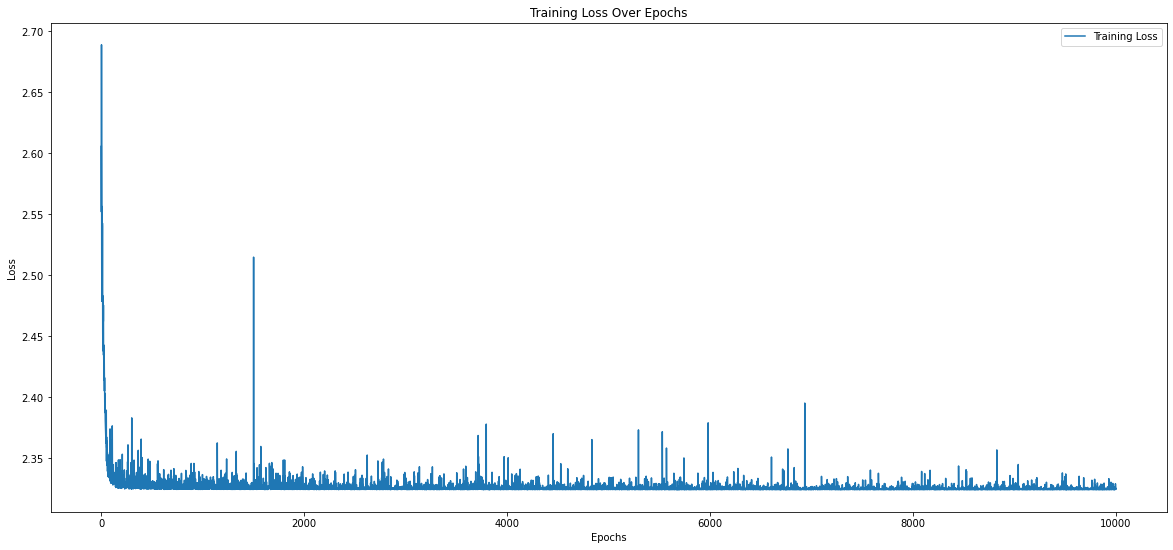

In [119]:
# Plotting the loss
plt.figure(figsize=(20, 9))
plt.plot(range(epoch), history_loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()